# Data Access

In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import numpy as np
import matplotlib.image as mpimg
import os
from os import listdir
from sklearn.datasets import load_files

from os.path import isfile, join
from random import sample
from tqdm.notebook import tqdm
from keras.utils.np_utils import to_categorical   
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import array_to_img, img_to_array, load_img


Using TensorFlow backend.


In [2]:
def load_data(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels

In [3]:
#read data

data = 'C:/Users/Zhenkun/Desktop/GU/590/final_project/data_part'
x, y, labels = load_data(data)


In [4]:
#split data

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=1)


In [5]:
# change type

def image_to_array(files):
    images_as_array=[]
    for file in files:
        images_as_array.append(img_to_array(load_img(file)))
    return images_as_array

In [6]:
X_train = np.array(image_to_array(X_train))
X_valid = np.array(image_to_array(X_valid))
X_test = np.array(image_to_array(X_test))

In [7]:
X_train=np.asarray(X_train).astype('float32')/255
y_train=np.asarray(y_train).reshape(-1,1)
y_train_cat = to_categorical(y_train, num_classes=10)
print((X_train.shape,y_train_cat.shape))

((1039, 224, 224, 3), (1039, 10))


In [8]:
X_test = np.asarray(X_test).astype('float32')/255
y_test = np.asarray(y_test).reshape(-1,1)
y_test_cat = to_categorical(y_test, num_classes=10)
print((X_test.shape,y_test_cat.shape))

((325, 224, 224, 3), (325, 10))


In [9]:
X_valid = np.asarray(X_valid).astype('float32')/255
y_valid = np.asarray(y_valid).reshape(-1,1)
y_valid_cat = to_categorical(y_valid, num_classes=10)
print((X_valid.shape,y_valid_cat.shape))

((260, 224, 224, 3), (260, 10))


# ResNet



In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout,GlobalMaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
import tensorflow as tf


In [11]:
# use Resnet model
base_model=ResNet50(include_top=False, weights = 'imagenet', input_shape = (224,224,3), classes = y_test_cat.shape[1])

In [12]:

#add layers and compile model
ResNet50=Sequential()
ResNet50.add(base_model)
for layer in ResNet50.layers:
    layer.trainable = True
ResNet50.add(GlobalMaxPooling2D())
ResNet50.add(Dense(128,activation=('tanh')))
ResNet50.add(Dense(10,activation=('softmax')))
ResNet50.summary()


In [13]:
#add layers 
VGG19 = tfk.Sequential()

VGG19.add(base_model)
for layer in VGG19.layers:
    layer.trainable = False
VGG19.add(tfkl.Dense(128,activation=('relu')))
VGG19.add(tfkl.GlobalMaxPooling2D())
VGG19.add(tfkl.Dense(10,activation=('softmax')))
VGG19.compile(optimizer=tfk.optimizers.Adam(),
              loss=tfk.losses.CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
VGG19.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
dense (Dense)                (None, 7, 7, 128)         65664     
_________________________________________________________________
global_max_pooling2d (Global (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 20,091,338
Trainable params: 66,954
Non-trainable params: 20,024,384
_________________________________________________________________


In [15]:
#add early stop and compile model

Early_sp = EarlyStopping(monitor = 'val_accuracy', patience = 3,restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
ResNet50.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
# train model
ResNet50_results=ResNet50.fit(X_train, y_train_cat,
                        batch_size= 32,
                        epochs = 20,
                        shuffle=True,
                        validation_data=(X_valid, y_valid_cat),
                        callbacks = [Early_sp,reduce_lr])
ResNet50.save('ResNet50_model_part') 

Train on 1039 samples, validate on 260 samples
Epoch 1/20
1039/1039 [==============================] - ETA: 34s - loss: 2.3240 - accuracy: 0.062 - ETA: 18s - loss: 2.3283 - accuracy: 0.031 - ETA: 13s - loss: 2.3105 - accuracy: 0.083 - ETA: 10s - loss: 2.3077 - accuracy: 0.078 - ETA: 9s - loss: 2.2941 - accuracy: 0.125 - ETA: 8s - loss: 2.2971 - accuracy: 0.11 - ETA: 7s - loss: 2.2807 - accuracy: 0.16 - ETA: 6s - loss: 2.2823 - accuracy: 0.14 - ETA: 6s - loss: 2.2823 - accuracy: 0.14 - ETA: 5s - loss: 2.2802 - accuracy: 0.14 - ETA: 5s - loss: 2.2848 - accuracy: 0.13 - ETA: 5s - loss: 2.2801 - accuracy: 0.14 - ETA: 5s - loss: 2.2805 - accuracy: 0.13 - ETA: 4s - loss: 2.2785 - accuracy: 0.14 - ETA: 4s - loss: 2.2762 - accuracy: 0.15 - ETA: 4s - loss: 2.2753 - accuracy: 0.15 - ETA: 4s - loss: 2.2686 - accuracy: 0.17 - ETA: 4s - loss: 2.2651 - accuracy: 0.18 - ETA: 3s - loss: 2.2601 - accuracy: 0.20 - ETA: 3s - loss: 2.2580 - accuracy: 0.21 - ETA: 3s - loss: 2.2550 - accuracy: 0.21 - ETA: 3

1039/1039 [==============================] - ETA: 3s - loss: 1.7398 - accuracy: 0.81 - ETA: 3s - loss: 1.7783 - accuracy: 0.75 - ETA: 3s - loss: 1.7952 - accuracy: 0.72 - ETA: 3s - loss: 1.8240 - accuracy: 0.68 - ETA: 3s - loss: 1.8202 - accuracy: 0.68 - ETA: 3s - loss: 1.8076 - accuracy: 0.70 - ETA: 3s - loss: 1.8274 - accuracy: 0.68 - ETA: 3s - loss: 1.8179 - accuracy: 0.69 - ETA: 3s - loss: 1.8235 - accuracy: 0.68 - ETA: 3s - loss: 1.8217 - accuracy: 0.68 - ETA: 3s - loss: 1.8295 - accuracy: 0.67 - ETA: 3s - loss: 1.8181 - accuracy: 0.68 - ETA: 3s - loss: 1.8276 - accuracy: 0.67 - ETA: 3s - loss: 1.8510 - accuracy: 0.65 - ETA: 3s - loss: 1.8449 - accuracy: 0.65 - ETA: 3s - loss: 1.8380 - accuracy: 0.66 - ETA: 3s - loss: 1.8356 - accuracy: 0.66 - ETA: 3s - loss: 1.8295 - accuracy: 0.67 - ETA: 2s - loss: 1.8281 - accuracy: 0.66 - ETA: 2s - loss: 1.8219 - accuracy: 0.67 - ETA: 2s - loss: 1.8218 - accuracy: 0.67 - ETA: 2s - loss: 1.8158 - accuracy: 0.68 - ETA: 2s - loss: 1.8190 - accura

1039/1039 [==============================] - ETA: 3s - loss: 1.8344 - accuracy: 0.62 - ETA: 3s - loss: 1.6849 - accuracy: 0.78 - ETA: 3s - loss: 1.6264 - accuracy: 0.85 - ETA: 3s - loss: 1.6191 - accuracy: 0.87 - ETA: 3s - loss: 1.6398 - accuracy: 0.86 - ETA: 3s - loss: 1.6532 - accuracy: 0.84 - ETA: 3s - loss: 1.6657 - accuracy: 0.83 - ETA: 3s - loss: 1.6716 - accuracy: 0.82 - ETA: 3s - loss: 1.6793 - accuracy: 0.81 - ETA: 3s - loss: 1.6885 - accuracy: 0.80 - ETA: 3s - loss: 1.6758 - accuracy: 0.81 - ETA: 3s - loss: 1.6899 - accuracy: 0.80 - ETA: 3s - loss: 1.6968 - accuracy: 0.79 - ETA: 3s - loss: 1.6925 - accuracy: 0.79 - ETA: 3s - loss: 1.6949 - accuracy: 0.79 - ETA: 2s - loss: 1.7075 - accuracy: 0.78 - ETA: 2s - loss: 1.6981 - accuracy: 0.79 - ETA: 2s - loss: 1.6922 - accuracy: 0.79 - ETA: 2s - loss: 1.6940 - accuracy: 0.79 - ETA: 2s - loss: 1.6958 - accuracy: 0.79 - ETA: 2s - loss: 1.6973 - accuracy: 0.79 - ETA: 2s - loss: 1.6955 - accuracy: 0.79 - ETA: 2s - loss: 1.6993 - accura

1039/1039 [==============================] - ETA: 3s - loss: 1.5935 - accuracy: 0.93 - ETA: 3s - loss: 1.6225 - accuracy: 0.90 - ETA: 3s - loss: 1.5978 - accuracy: 0.91 - ETA: 3s - loss: 1.6027 - accuracy: 0.90 - ETA: 3s - loss: 1.6359 - accuracy: 0.86 - ETA: 3s - loss: 1.6362 - accuracy: 0.85 - ETA: 3s - loss: 1.6427 - accuracy: 0.84 - ETA: 3s - loss: 1.6373 - accuracy: 0.85 - ETA: 3s - loss: 1.6331 - accuracy: 0.85 - ETA: 3s - loss: 1.6238 - accuracy: 0.86 - ETA: 3s - loss: 1.6208 - accuracy: 0.86 - ETA: 3s - loss: 1.6203 - accuracy: 0.86 - ETA: 3s - loss: 1.6180 - accuracy: 0.86 - ETA: 3s - loss: 1.6124 - accuracy: 0.87 - ETA: 3s - loss: 1.6110 - accuracy: 0.87 - ETA: 3s - loss: 1.6198 - accuracy: 0.85 - ETA: 2s - loss: 1.6223 - accuracy: 0.85 - ETA: 2s - loss: 1.6176 - accuracy: 0.86 - ETA: 2s - loss: 1.6103 - accuracy: 0.86 - ETA: 2s - loss: 1.6158 - accuracy: 0.86 - ETA: 2s - loss: 1.6150 - accuracy: 0.86 - ETA: 2s - loss: 1.6146 - accuracy: 0.86 - ETA: 2s - loss: 1.6149 - accura

1039/1039 [==============================] - ETA: 5s - loss: 1.6019 - accuracy: 0.87 - ETA: 4s - loss: 1.5965 - accuracy: 0.87 - ETA: 4s - loss: 1.5935 - accuracy: 0.87 - ETA: 4s - loss: 1.5632 - accuracy: 0.90 - ETA: 4s - loss: 1.5556 - accuracy: 0.91 - ETA: 4s - loss: 1.5503 - accuracy: 0.91 - ETA: 4s - loss: 1.5571 - accuracy: 0.91 - ETA: 3s - loss: 1.5682 - accuracy: 0.89 - ETA: 3s - loss: 1.5775 - accuracy: 0.88 - ETA: 3s - loss: 1.5779 - accuracy: 0.88 - ETA: 3s - loss: 1.5804 - accuracy: 0.88 - ETA: 3s - loss: 1.5836 - accuracy: 0.88 - ETA: 3s - loss: 1.5843 - accuracy: 0.88 - ETA: 3s - loss: 1.5876 - accuracy: 0.88 - ETA: 3s - loss: 1.5798 - accuracy: 0.89 - ETA: 3s - loss: 1.5766 - accuracy: 0.89 - ETA: 3s - loss: 1.5815 - accuracy: 0.88 - ETA: 3s - loss: 1.5852 - accuracy: 0.88 - ETA: 3s - loss: 1.5850 - accuracy: 0.88 - ETA: 2s - loss: 1.5826 - accuracy: 0.88 - ETA: 2s - loss: 1.5773 - accuracy: 0.89 - ETA: 2s - loss: 1.5762 - accuracy: 0.89 - ETA: 2s - loss: 1.5771 - accura

1039/1039 [==============================] - ETA: 3s - loss: 1.5381 - accuracy: 0.93 - ETA: 3s - loss: 1.5027 - accuracy: 0.96 - ETA: 3s - loss: 1.5319 - accuracy: 0.93 - ETA: 3s - loss: 1.5758 - accuracy: 0.89 - ETA: 3s - loss: 1.5541 - accuracy: 0.91 - ETA: 3s - loss: 1.5608 - accuracy: 0.90 - ETA: 3s - loss: 1.5810 - accuracy: 0.88 - ETA: 3s - loss: 1.5717 - accuracy: 0.89 - ETA: 3s - loss: 1.5650 - accuracy: 0.89 - ETA: 3s - loss: 1.5559 - accuracy: 0.90 - ETA: 3s - loss: 1.5480 - accuracy: 0.91 - ETA: 3s - loss: 1.5461 - accuracy: 0.91 - ETA: 3s - loss: 1.5493 - accuracy: 0.91 - ETA: 3s - loss: 1.5518 - accuracy: 0.91 - ETA: 3s - loss: 1.5466 - accuracy: 0.91 - ETA: 3s - loss: 1.5416 - accuracy: 0.92 - ETA: 3s - loss: 1.5480 - accuracy: 0.91 - ETA: 2s - loss: 1.5501 - accuracy: 0.91 - ETA: 2s - loss: 1.5523 - accuracy: 0.91 - ETA: 2s - loss: 1.5511 - accuracy: 0.91 - ETA: 2s - loss: 1.5502 - accuracy: 0.91 - ETA: 2s - loss: 1.5588 - accuracy: 0.90 - ETA: 2s - loss: 1.5574 - accura

1039/1039 [==============================] - ETA: 3s - loss: 1.5912 - accuracy: 0.87 - ETA: 3s - loss: 1.5572 - accuracy: 0.90 - ETA: 3s - loss: 1.5661 - accuracy: 0.89 - ETA: 3s - loss: 1.5561 - accuracy: 0.90 - ETA: 3s - loss: 1.5388 - accuracy: 0.92 - ETA: 3s - loss: 1.5568 - accuracy: 0.90 - ETA: 3s - loss: 1.5601 - accuracy: 0.91 - ETA: 3s - loss: 1.5708 - accuracy: 0.89 - ETA: 3s - loss: 1.5599 - accuracy: 0.90 - ETA: 3s - loss: 1.5567 - accuracy: 0.91 - ETA: 3s - loss: 1.5647 - accuracy: 0.90 - ETA: 3s - loss: 1.5564 - accuracy: 0.91 - ETA: 3s - loss: 1.5496 - accuracy: 0.91 - ETA: 3s - loss: 1.5438 - accuracy: 0.92 - ETA: 2s - loss: 1.5467 - accuracy: 0.92 - ETA: 2s - loss: 1.5419 - accuracy: 0.92 - ETA: 2s - loss: 1.5375 - accuracy: 0.93 - ETA: 2s - loss: 1.5337 - accuracy: 0.93 - ETA: 2s - loss: 1.5335 - accuracy: 0.93 - ETA: 2s - loss: 1.5330 - accuracy: 0.93 - ETA: 2s - loss: 1.5356 - accuracy: 0.93 - ETA: 2s - loss: 1.5380 - accuracy: 0.92 - ETA: 2s - loss: 1.5401 - accura

1039/1039 [==============================] - ETA: 3s - loss: 1.5263 - accuracy: 0.93 - ETA: 3s - loss: 1.5254 - accuracy: 0.93 - ETA: 3s - loss: 1.5053 - accuracy: 0.95 - ETA: 3s - loss: 1.5114 - accuracy: 0.95 - ETA: 3s - loss: 1.5140 - accuracy: 0.95 - ETA: 3s - loss: 1.5060 - accuracy: 0.95 - ETA: 3s - loss: 1.5087 - accuracy: 0.95 - ETA: 3s - loss: 1.5256 - accuracy: 0.93 - ETA: 3s - loss: 1.5395 - accuracy: 0.92 - ETA: 3s - loss: 1.5442 - accuracy: 0.91 - ETA: 3s - loss: 1.5479 - accuracy: 0.91 - ETA: 3s - loss: 1.5456 - accuracy: 0.91 - ETA: 3s - loss: 1.5577 - accuracy: 0.90 - ETA: 3s - loss: 1.5554 - accuracy: 0.90 - ETA: 2s - loss: 1.5534 - accuracy: 0.90 - ETA: 2s - loss: 1.5518 - accuracy: 0.91 - ETA: 2s - loss: 1.5502 - accuracy: 0.91 - ETA: 2s - loss: 1.5454 - accuracy: 0.91 - ETA: 2s - loss: 1.5444 - accuracy: 0.91 - ETA: 2s - loss: 1.5464 - accuracy: 0.91 - ETA: 2s - loss: 1.5482 - accuracy: 0.91 - ETA: 2s - loss: 1.5471 - accuracy: 0.91 - ETA: 2s - loss: 1.5438 - accura

1039/1039 [==============================] - ETA: 3s - loss: 1.5269 - accuracy: 0.93 - ETA: 3s - loss: 1.5543 - accuracy: 0.90 - ETA: 3s - loss: 1.5846 - accuracy: 0.87 - ETA: 3s - loss: 1.5549 - accuracy: 0.90 - ETA: 3s - loss: 1.5486 - accuracy: 0.91 - ETA: 3s - loss: 1.5543 - accuracy: 0.90 - ETA: 3s - loss: 1.5586 - accuracy: 0.90 - ETA: 3s - loss: 1.5473 - accuracy: 0.91 - ETA: 3s - loss: 1.5577 - accuracy: 0.90 - ETA: 3s - loss: 1.5545 - accuracy: 0.90 - ETA: 3s - loss: 1.5518 - accuracy: 0.90 - ETA: 3s - loss: 1.5493 - accuracy: 0.91 - ETA: 3s - loss: 1.5438 - accuracy: 0.91 - ETA: 3s - loss: 1.5425 - accuracy: 0.91 - ETA: 2s - loss: 1.5373 - accuracy: 0.92 - ETA: 2s - loss: 1.5402 - accuracy: 0.92 - ETA: 2s - loss: 1.5393 - accuracy: 0.92 - ETA: 2s - loss: 1.5384 - accuracy: 0.92 - ETA: 2s - loss: 1.5349 - accuracy: 0.92 - ETA: 2s - loss: 1.5375 - accuracy: 0.92 - ETA: 2s - loss: 1.5368 - accuracy: 0.92 - ETA: 2s - loss: 1.5363 - accuracy: 0.92 - ETA: 2s - loss: 1.5359 - accura

1039/1039 [==============================] - ETA: 3s - loss: 1.5216 - accuracy: 0.93 - ETA: 3s - loss: 1.5539 - accuracy: 0.90 - ETA: 3s - loss: 1.5633 - accuracy: 0.89 - ETA: 3s - loss: 1.5679 - accuracy: 0.89 - ETA: 3s - loss: 1.5471 - accuracy: 0.91 - ETA: 3s - loss: 1.5432 - accuracy: 0.91 - ETA: 3s - loss: 1.5323 - accuracy: 0.92 - ETA: 3s - loss: 1.5465 - accuracy: 0.91 - ETA: 3s - loss: 1.5441 - accuracy: 0.91 - ETA: 3s - loss: 1.5481 - accuracy: 0.91 - ETA: 3s - loss: 1.5459 - accuracy: 0.91 - ETA: 3s - loss: 1.5390 - accuracy: 0.92 - ETA: 3s - loss: 1.5470 - accuracy: 0.91 - ETA: 3s - loss: 1.5494 - accuracy: 0.91 - ETA: 2s - loss: 1.5437 - accuracy: 0.91 - ETA: 2s - loss: 1.5463 - accuracy: 0.91 - ETA: 2s - loss: 1.5414 - accuracy: 0.91 - ETA: 2s - loss: 1.5372 - accuracy: 0.92 - ETA: 2s - loss: 1.5334 - accuracy: 0.92 - ETA: 2s - loss: 1.5299 - accuracy: 0.93 - ETA: 2s - loss: 1.5295 - accuracy: 0.93 - ETA: 2s - loss: 1.5292 - accuracy: 0.93 - ETA: 2s - loss: 1.5290 - accura

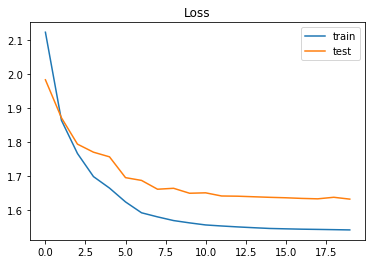

In [16]:
plt.title('Loss')
plt.plot(ResNet50_results.history['loss'], label='train')
plt.plot(ResNet50_results.history['val_loss'], label='test')
plt.legend()
plt.show()

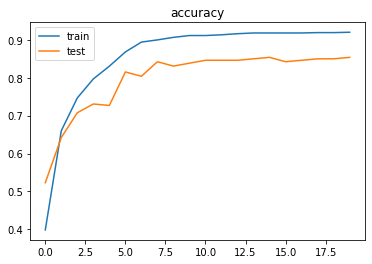

In [17]:
plt.title('accuracy')
plt.plot(ResNet50_results.history['accuracy'], label='train')
plt.plot(ResNet50_results.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [21]:
from sklearn.metrics import accuracy_score 

pred = ResNet50.predict(X_test)
pred = pred.argmax(axis=1)
acc = accuracy_score(y_test, pred) 

In [22]:
print('Accuracy is',acc)

Accuracy is 0.8553846153846154
